In [1]:
from openquantumcomputing import QAOAPortfolioOptimization, QAOABase
from openquantumcomputing import Statistic
import asset_loader

from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from qiskit.visualization import *
from tqdm import tqdm
import itertools


from importlib import reload

c:\Users\havardh\playground-win\quantumComputing\optimization\PortfolioOptimization\asset_loader.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=-30)


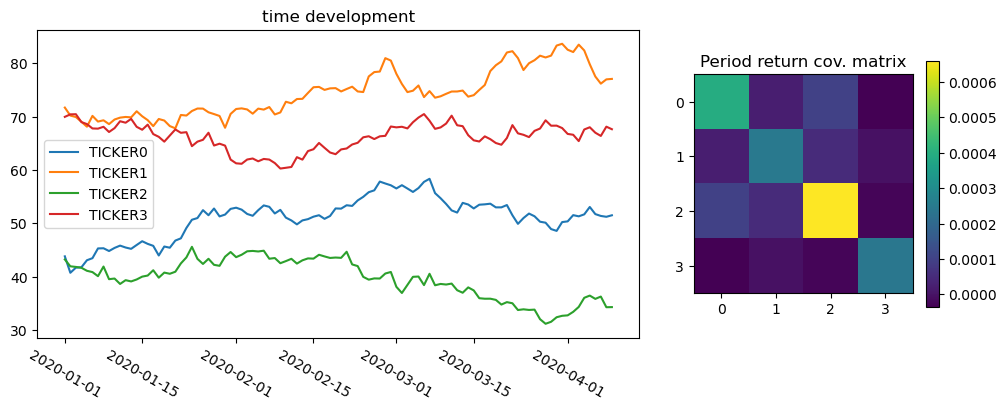

In [2]:
reload(asset_loader)
assets = asset_loader.AssetData(4, 100, seed=13)
assets.plotAssets()

params = {
    "risk" : 0.5,
    "budget": 2,
    "penalty": 4,
    "cov_matrix": assets.cov_matrix,
    "exp_return": assets.exp_return,
    "usebarrier": False,
    "parameterize": False
}

In [3]:
reload(QAOAPortfolioOptimization)
qaoa_portopt = QAOAPortfolioOptimization.QAOAPortfolioOptimization(params)

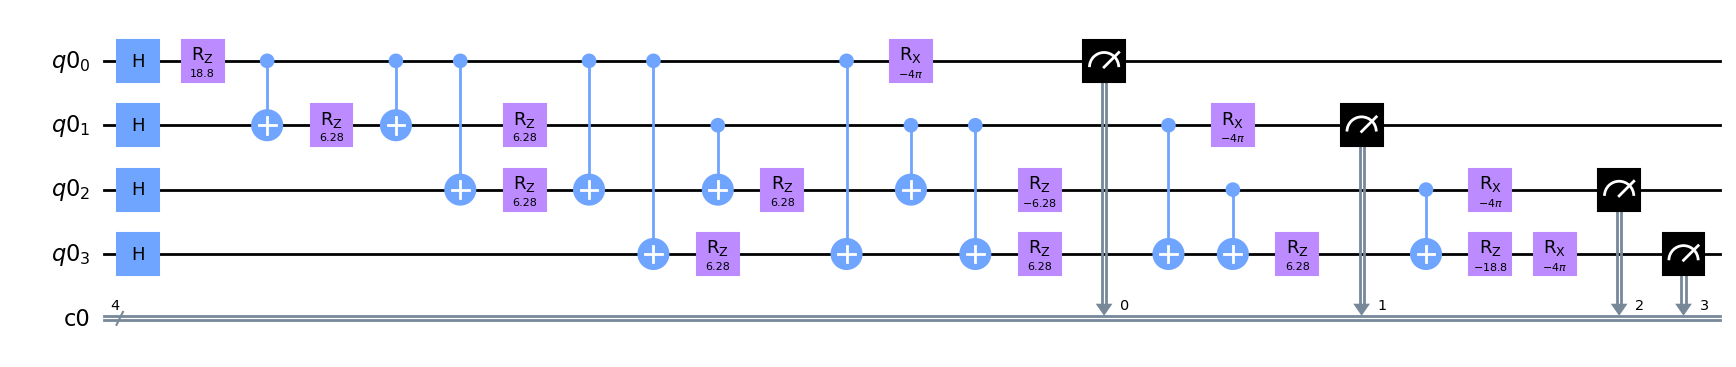

In [4]:
display(qaoa_portopt.createCircuit(np.array((np.pi,2*np.pi)),1).draw(output='mpl'))


[0.00048258 0.00031392 0.00078376 0.0001755 ]
[0.00056995 0.00033647 0.00060782 0.00024153]
0.0002465187338574156
0.0002465187338574156
0.0002465187338574156
[1. 1. 1.]


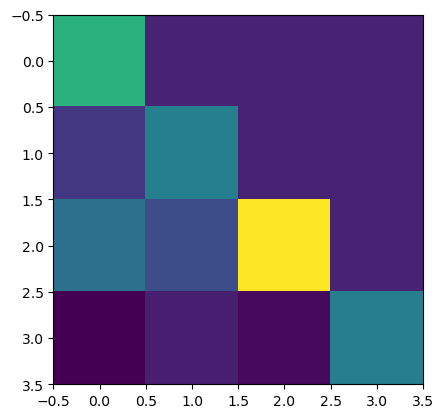

In [5]:
tril_cov = np.tril(qaoa_portopt.cov_matrix + np.tril(qaoa_portopt.cov_matrix, k=-1))
plt.imshow(tril_cov)
print(np.sum(qaoa_portopt.cov_matrix, axis=0))
print(np.sum(tril_cov, axis=0))

x = np.random.rand(4)
print(x.T@(qaoa_portopt.cov_matrix@x))
print(x@(qaoa_portopt.cov_matrix@x))
print(x.T@(tril_cov@x))

print(np.ones((3)))

In [6]:
print(qaoa_portopt.isFeasible("0010"))
print(qaoa_portopt.cost("0010"))
print(qaoa_portopt.cost("0101"))
print(qaoa_portopt.cost("1100"))

print(qaoa_portopt.cost("1000"))



False
-4.002333065994415
0.00039152639381967447
0.0023381735562253425
-3.998367003059391


In [7]:

print("solutions:")
best_sol = None
best_cost = None
for s in [''.join(i) for i in itertools.product('01', repeat = assets.N)]:
    c = qaoa_portopt.cost(s)
    if best_sol is None:
        best_sol = s
        best_cost = c
    elif c > best_cost:
        best_sol = s
        best_cost = c

    if qaoa_portopt.isFeasible(s):
        print(s, c)
    else: 
        print(s, '\t', c)

print("--------------------")
print("Best sol is "+ best_sol + " with cost " + str(best_cost))

solutions:
0000 	 -16.0
0001 	 -4.000341395451567
0010 	 -4.002333065994415
0011 -0.0026484871652812103
0100 	 -3.9992716588144965
0101 0.00039152639381967447
0110 -0.0016550158624220046
0111 	 -4.001965856373403
1000 	 -3.998367003059391
1001 0.0013270681176713595
1010 -0.0007997440273825873
1011 	 -4.001079698569619
1100 0.0023381735562253425
1101 	 -3.9979631746068307
1110 	 -4.0001448584652906
1111 	 -16.000420232347622
--------------------
Best sol is 1100 with cost 0.0023381735562253425


## Sample cost landscape

In [8]:
qasm_sim = Aer.get_backend('qasm_simulator')

In [9]:
qaoa_portopt.sample_cost_landscape(qasm_sim, 1024, angles={"gamma": [0,np.pi,50], "beta": [0,np.pi,40]})

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done


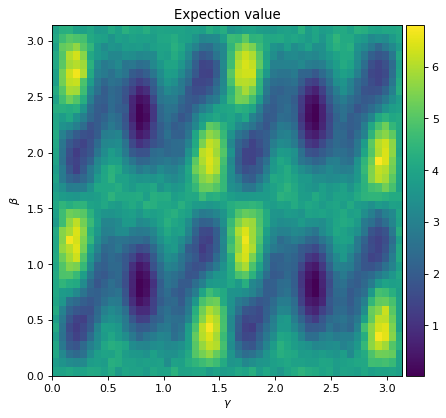

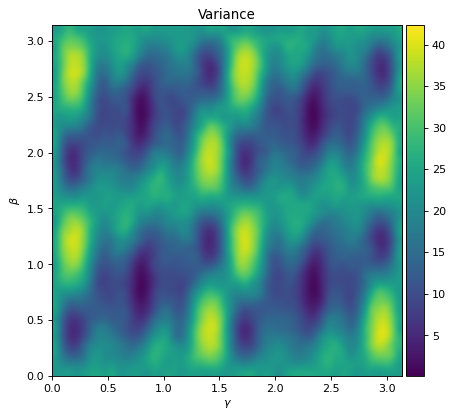

In [10]:
def plotLandscape(field, title, interpolation='bicubic'):
    f = plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
    _=plt.xlabel(r'$\gamma$')
    _=plt.ylabel(r'$\beta$')
    ax = plt.gca()
    _=plt.title(title)
    im = ax.imshow(field, interpolation=interpolation, origin='lower', extent=[0,np.pi,0,np.pi])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    _=plt.colorbar(im, cax=cax)

plotLandscape(qaoa_portopt.E, "Expection value", interpolation="None")
#plotLandscape(qaoa_portopt.E, r'CVaR with $\alpha$='+str(qaoaec_cvar.params["alpha"])) #, interpolation="None")
plotLandscape(qaoa_portopt.Var, "Variance")


In [11]:
maxdepth=7
for i in tqdm(range(maxdepth)):
    qaoa_portopt.increase_depth(qasm_sim, 1024)

 14%|█▍        | 1/7 [00:00<00:04,  1.49it/s]

cost(depth= 1 )= 0.00021457896696780443


 29%|██▊       | 2/7 [00:01<00:04,  1.14it/s]

cost(depth= 2 )= 1.649510502404079


 43%|████▎     | 3/7 [00:03<00:05,  1.47s/it]

cost(depth= 3 )= 1.1403575896676548


 57%|█████▋    | 4/7 [00:06<00:06,  2.09s/it]

cost(depth= 4 )= 0.6565295001692869


 71%|███████▏  | 5/7 [00:11<00:05,  2.84s/it]

cost(depth= 5 )= 1.043023445517185


 86%|████████▌ | 6/7 [00:16<00:03,  3.88s/it]

cost(depth= 6 )= 0.1883481226451944


100%|██████████| 7/7 [00:23<00:00,  3.36s/it]

cost(depth= 7 )= 0.4221436943786407


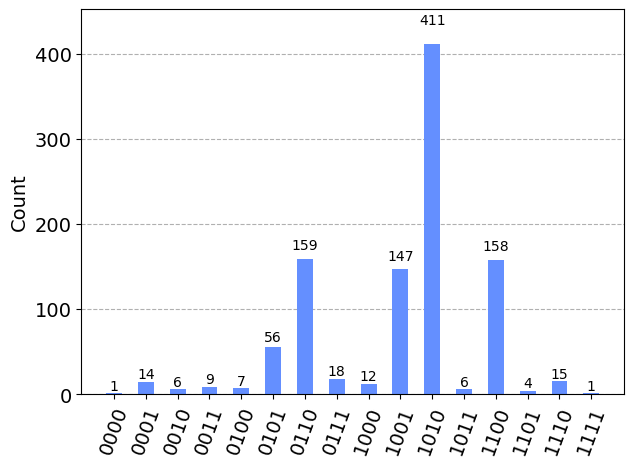

In [12]:
hist=qaoa_portopt.hist(qaoa_portopt.angles_hist['d'+str(maxdepth)+'_final'], qasm_sim,1024)
plot_histogram(hist)

In [13]:
sorted_hist = dict(sorted(hist.items(), key=lambda item: item[1], reverse=True))

for s, freq in sorted_hist.items():
    if qaoa_portopt.isFeasible(s):
        print(qaoa_portopt.cost(s), s, freq)
    else:
        print("\t", qaoa_portopt.cost(s), s, freq)

print("Classical best result: ", (best_sol, best_cost))

-0.0007997440273825873 1010 411
-0.0016550158624220046 0110 159
0.0023381735562253425 1100 158
0.0013270681176713595 1001 147
0.00039152639381967447 0101 56
	 -4.001965856373403 0111 18
	 -4.0001448584652906 1110 15
	 -4.000341395451567 0001 14
	 -3.998367003059391 1000 12
-0.0026484871652812103 0011 9
	 -3.9992716588144965 0100 7
	 -4.001079698569619 1011 6
	 -4.002333065994415 0010 6
	 -3.9979631746068307 1101 4
	 -16.000420232347622 1111 1
	 -16.0 0000 1
Classical best result:  ('1100', 0.0023381735562253425)
